In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models
import random
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

Mount Google Drive and List Directories in a Specified Path



In [ ]:
import os
path = '/content/drive/MyDrive/עבודה בינה מלאכותית/data_base'

directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

print(directories)

['nonpd', 'pd', 'Prodromal', 'תמונות תסמינים שלא השתמשנו בהם לפיתוח מודל בגלל עודף']


Define Source Directories and Data Split Ratios

In [ ]:
import os
import pandas as pd
import random

# נתיב לתקיות החולים והלא חולים

path = r'/content/drive/MyDrive/עבודה בינה מלאכותית/data_base'
Prodromal_dir = path + r'/Prodromal'
healthy_dir = path + r'/nonpd'



healthy_df =  pd.read_csv(path + r'/Healthy_list_for_model_3,4.csv')

# יצירת רשימות של התמונות והלייבלים
images = []
labels = []

# הוספת תמונות חולים
for filename in os.listdir(Prodromal_dir):
    images.append(os.path.join(Prodromal_dir, filename))
    labels.append('Prodromal')

random.seed(25)
random.shuffle(images)

images = images[:healthy_df.shape[0]]
labels = labels[:len(images)]


# הוספת תמונות לא חולים
for _, row in healthy_df.iterrows():
    filename = str(row['File Name'])
    images.append(os.path.join(healthy_dir, filename))
    labels.append('NONPD')

# צעד 3: יצירת דאטה פריים
df = pd.DataFrame({
    'Image': images,
    'Label': labels
})



print(f'prodromal - nonpd ratio -> {df[df["Label"] == "Prodromal"].shape[0]//df[df["Label"] == "NONPD"].shape[0] }:1')


# הצגת הדאטה פריים
df.head()

prodromal - nonpd ratio -> 1:1


,Image,Label
0,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal
1,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal
2,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal
3,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal
4,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,Prodromal



Load and Preprocess Image Dataset with Train, Validation, and Test Splits

In [ ]:

# Paths to the folders
Prodromal_dir = path + '/Prodromal'  # Directory containing patient (PD) images
nonpatients_dir = path + '/nonpd'  # Directory containing non-patient (NONPD) imagesDirectory containing non-patient (NONPD) images

# Parameters for dataset splitting
TRAIN_SPLIT = 0.64  # Fraction of data for training
VAL_SPLIT = 0.16    # Fraction of data for validation
TEST_SPLIT = 0.20   # Fraction of data for testing
SEED = 42           # Random seed for reproducibility


# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=(1 - TRAIN_SPLIT), random_state=SEED, stratify=df["Label"])
val_df, test_df = train_test_split(temp_df, test_size=(TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)), random_state=SEED, stratify=temp_df["Label"])

# Function to load a dataset from a DataFrame
def load_dataset(dataframe, image_size, batch_size, shuffle=True):
    file_paths = dataframe["Image"].values  # Extract file paths
    labels = dataframe["Label"].values  # Extract labels
    labels = np.where(labels == 'Prodromal', 1, 0)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))  # Create TensorFlow dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=SEED)  # Shuffle data if needed

    def load_and_preprocess_image(file_path, label):
        img = tf.io.read_file(file_path)  # Read image file
        img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG images; use decode_png for PNG
        img = tf.image.resize(img, image_size)  # Resize image to specified dimensions
        return img, label

    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)  # Batch and prefetch data

# Parameters for loading the dataset
IMG_SIZE = (224, 224)  # Image dimensions
BATCH_SIZE = 32  # Batch size

# Load datasets
train_ds = load_dataset(train_df, IMG_SIZE, BATCH_SIZE, shuffle=True)  # Training dataset
val_ds = load_dataset(val_df, IMG_SIZE, BATCH_SIZE, shuffle=True)  # Validation dataset
test_ds = load_dataset(test_df, IMG_SIZE, BATCH_SIZE, shuffle=False)  # Test dataset

# The datasets `train_ds`, `val_ds`, and `test_ds` are now ready for use


Optimize Dataset Prefetching for Improved Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE  # Enable TensorFlow's automatic tuning for performance optimization

train_ds = train_ds.prefetch(AUTOTUNE)  # Prefetch training dataset for faster loading
val_ds   = val_ds.prefetch(AUTOTUNE)   # Prefetch validation dataset for faster loading
test_ds  = test_ds.prefetch(AUTOTUNE)  # Prefetch test dataset for faster loading


Define a Data Augmentation Layer for Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.005),       # Apply a small random rotation (0.5%)
    layers.RandomZoom(0.1),             # Apply a small random zoom
    layers.RandomContrast(0.05),        # Apply a slight random contrast adjustment
], name="augmentation_layer")  # Name the layer for easier identification


Map Data Augmentation and Preprocessing Functions to Datasets

In [ ]:
def augment_and_preprocess(image, label):
    image = data_augmentation(image)  # Apply data augmentation to the image
    image = preprocess_input(image)  # Preprocess the image for ResNet50
    return image, label

def preprocess_only(image, label):
    image = preprocess_input(image)  # Preprocess the image for ResNet50 without augmentation
    return image, label

train_ds = train_ds.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)  # Apply augmentation and preprocessing to the training dataset
val_ds = val_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)             # Apply preprocessing only to the validation dataset
test_ds = test_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)           # Apply preprocessing only to the test dataset


Define a Custom F1 Score Metric for TensorFlow/Keras with Improved Casting

In [ ]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # Convert both y_true and y_pred to float32 to prevent data type issues
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    tp = K.sum(K.round(y_true * y_pred))  # Calculate true positives
    predicted_positives = K.sum(K.round(y_pred))  # Calculate predicted positives
    possible_positives  = K.sum(K.round(y_true))  # Calculate possible positives

    precision = tp / (predicted_positives + K.epsilon())  # Calculate precision
    recall    = tp / (possible_positives + K.epsilon())   # Calculate recall

    # Return the F1 score: harmonic mean of precision and recall
    return 2 * (precision * recall) / (precision + recall + K.epsilon())


Build a Transfer Learning Model with my model as the Base

In [ ]:
from tensorflow.keras.models import load_model

# הנתיב שבו שמרת את המודל שלך
model_path = '/content/drive/MyDrive/עבודה בינה מלאכותית/output_models/'

my_model  = load_model(model_path + r"(2)/First_model_Transfer_Learning_PD_NONPD.h5")

# בודקים אם המודל נטען כראוי
my_model.summary()

new_model = models.Model(inputs=my_model.input, outputs=my_model.layers[-3].output)  # הסרה של Dropout ו-Dense (רק שימור את השכבה שלפני)

# בודקים אם המודל החדש יצא כראוי
new_model.summary()

Model: "Light_vs_Severe_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,763 (89.99 MB)

 Trainable params: 4,467,713 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 2 (12.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [ ]:
for layer in new_model.layers:
    layer.trainable = False

import tensorflow as tf
from tensorflow.keras import layers, models

# מקפיאים את המודל כך שלא יתעדכן במהלך האימון
new_model.trainable = False

# הגדרת קלט חדש למודל
inputs = layers.Input(shape=IMG_SIZE + (3,))  # הגדרת גודל הקלט שלך

# העברת הקלט דרך המודל הבסיס שלך (שהוא המודל שלך)
x = new_model(inputs, training=False)

# הוספת שכבת Flatten (הופך את הפלט לווקטור חד-ממדי)
x = layers.Flatten()(x)

# הוספת שכבות Dense
x = layers.Dense(512, activation='relu')(x)  # שכבה ראשונה
x = layers.Dense(256, activation='relu')(x)  # שכבה שנייה
x = layers.Dense(128, activation='relu')(x)  # שכבה שלישית
x = layers.Dense(64, activation='relu')(x)   # שכבה רביעית
x = layers.Dense(32, activation='relu')(x)   # שכבה חמישית

# הוספת Dropout עם שיעור של 0.5
x = layers.Dropout(0.5)(x)

# הוספת שכבת פלט עם Sigmoid (לבעיה בינארית)
outputs = layers.Dense(1, activation='sigmoid')(x)

# יצירת המודל החדש
model_new_new = models.Model(inputs, outputs, name="model_new_new")

# הצגת סיכום המודל
model_new_new.summary()


Model: "model_new_new"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,811,393 (94.65 MB)

 Trainable params: 5,689,345 (21.70 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

Fine-Tune the Last 20 Layers of the Base Model

In [17]:
# Recompile the model with a lower learning rate for fine-tuning
model_new_new.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a smaller learning rate for fine-tuning
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=[
        'accuracy',  # Track accuracy during training
        tf.keras.metrics.Precision(name='precision'),  # Track precision
        tf.keras.metrics.Recall(name='recall'),  # Track recall
        f1_score  # Custom F1 score metric
    ]
)

FINE_TUNE_EPOCHS = 20  # Number of fine-tuning epochs
history_fine = model_new_new.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=FINE_TUNE_EPOCHS  # Train for additional fine-tuning epochs
)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 270s 14s/step - accuracy: 0.5580 - f1_score: 18.5068 - loss: 0.6939 - precision: 0.5235 - recall: 0.8329 - val_accuracy: 0.6214 - val_f1_score: 17.7241 - val_loss: 0.6508 - val_precision: 0.5702 - val_recall: 0.9857
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 208s 11s/step - accuracy: 0.6223 - f1_score: 18.0420 - loss: 0.6394 - precision: 0.5763 - recall: 0.8261 - val_accuracy: 0.7214 - val_f1_score: 16.7193 - val_loss: 0.6125 - val_precision: 0.6449 - val_recall: 0.9857
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 207s 11s/step - accuracy: 0.6690 - f1_score: 18.0832 - loss: 0.6091 - precision: 0.6323 - recall: 0.8208 - val_accuracy: 0.7929 - val_f1_score: 16.1300 - val_loss: 0.5681 - val_precision: 0.7113 - val_recall: 0.9857
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 199s 11s/step - accuracy: 0.7534 - f1_score: 17.4987 - loss: 0.5523 - precision: 0.6927 - recall: 0.8911 - val_accuracy: 0.8143 - val_f1_score: 15.9360 - val_loss: 0.5215 - val_precision: 0.7340 - val

Evaluate the Fine-Tuned Model on the Test Dataset

In [20]:
# After completing the fine-tuning (history_fine),
# evaluate the model on the test dataset to check final performance:
print("\nEvaluating Fine-Tuned Model on Test Data...")
test_loss, test_acc, test_prec, test_rec, test_f1 = model_new_new.evaluate(test_ds)  # Evaluate on test dataset

# Print evaluation results
print(f"Test Loss: {test_loss:.4f}")  # Loss on the test dataset
print(f"Test Accuracy: {test_acc:.4f}")  # Accuracy on the test dataset
print(f"Test Precision: {test_prec:.4f}")  # Precision on the test dataset
print(f"Test Recall: {test_rec:.4f}")  # Recall on the test dataset
print(f"Test F1: {test_f1:.4f}")  # F1 score on the test dataset



Evaluating Fine-Tuned Model on Test Data...
6/6 ━━━━━━━━━━━━━━━━━━━━ 66s 10s/step - accuracy: 0.9325 - f1_score: 16.1994 - loss: 0.1967 - precision: 0.8992 - recall: 0.9749
Test Loss: 0.1862
Test Accuracy: 0.9379
Test Precision: 0.9053
Test Recall: 0.9773
Test F1: 15.1996


Generate Predictions, Confusion Matrix, and Classification Report for Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


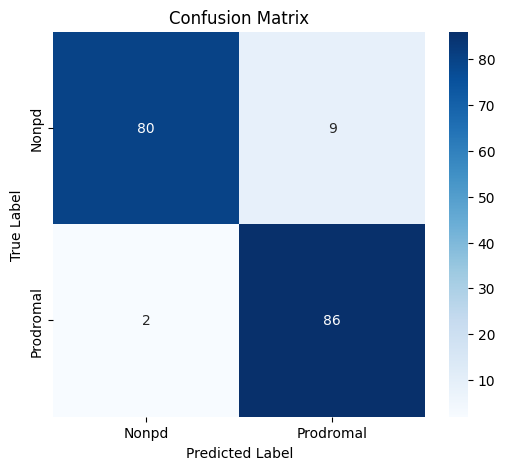


Confusion Matrix:
 [[80  9]
 [ 2 86]]

Classification Report:
                precision    recall  f1-score   support

    Nonpd (0)       0.98      0.90      0.94        89
Prodromal (1)       0.91      0.98      0.94        88

     accuracy                           0.94       177
    macro avg       0.94      0.94      0.94       177
 weighted avg       0.94      0.94      0.94       177



In [26]:
y_true = []  # True labels
y_pred = []  # Predicted labels

# Generate predictions for the test dataset
for images, labels in test_ds:
    preds = model_new_new.predict(images)  # Predict probabilities
    y_true.extend(labels.numpy().flatten())  # Collect true labels
    y_pred.extend((preds.flatten() > 0.5).astype(int))  # Convert probabilities to binary predictions


# Assuming you already have y_true and y_pred (true labels and predicted labels)
# y_true = ...
# y_pred = ...

# Step 1: Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 2: Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Nonpd", "Prodromal"], yticklabels=["Nonpd", "Prodromal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Generate the classification report
report = classification_report(y_true, y_pred, target_names=["Nonpd (0)", "Prodromal (1)"])

# Print results
print("\nConfusion Matrix:\n", cm)  # Display the confusion matrix
print("\nClassification Report:\n", report)  # Display precision, recall, F1-score, and support



Plot Training and Validation Accuracy and Loss Over Epochs

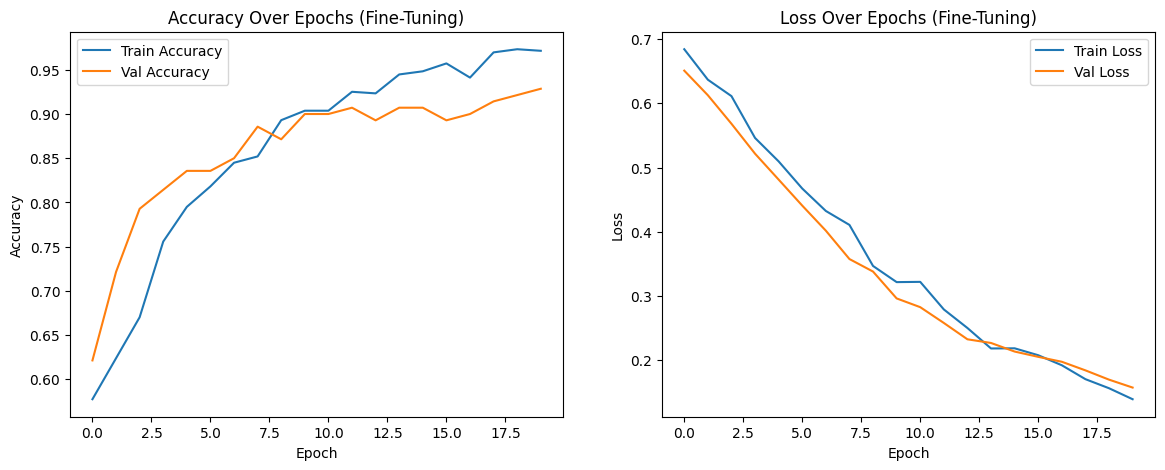

In [23]:
# עבור רק את ה-fine-tuning
acc = history_fine.history["accuracy"]  # Training accuracy for fine-tuning
val_acc = history_fine.history["val_accuracy"]  # Validation accuracy for fine-tuning
loss = history_fine.history["loss"]  # Training loss for fine-tuning
val_loss = history_fine.history["val_loss"]  # Validation loss for fine-tuning

epochs_range = range(len(acc))  # Total number of epochs for fine-tuning

plt.figure(figsize=(14, 5))

# גרף הדיוק
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")  # Training accuracy plot
plt.plot(epochs_range, val_acc, label="Val Accuracy")  # Validation accuracy plot
plt.title("Accuracy Over Epochs (Fine-Tuning)")  # Title for accuracy plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Accuracy")  # Y-axis label
plt.legend()  # Add legend

# גרף ההפסד
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")  # Training loss plot
plt.plot(epochs_range, val_loss, label="Val Loss")  # Validation loss plot
plt.title("Loss Over Epochs (Fine-Tuning)")  # Title for loss plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.legend()  # Add legend

plt.show()  # Display the plots


Save the Model and Its Weights

In [25]:
# Define the save path for the model and weights
save_path = '/content/drive/MyDrive/עבודה בינה מלאכותית/output_models/(4)/'

# Save the full model in TensorFlow's Keras format
model_new_new.save(save_path + 'second_model_Transfer_Learning_Prodromal _NONPD.keras')

# Save the full model in HDF5 format
model_new_new.save(save_path + 'second_model_Transfer_Learning_Prodromal _NONPD.h5')

# Save only the model's weights in HDF5 format
model_new_new.save_weights(save_path + 'second_model_Transfer_Learning_Prodromal _NONPD_weights.weights.h5')
